# **Team 8: the 3rd Bulgarian empire - Iteration 1 Notebook**

You are a team of junior data analysts working for Enchanted Estates, a magical real estate agency. The agency specializes in helping clients buy and sell properties across various realms in a fantastical world. Recently, the agency has noticed significant fluctuations in property trade values across different enclaves and realm types. They believe that understanding the factors influencing trade values will help them provide better advice to their clients and improve their magical marketing strategies. The agency has tasked your team with analyzing historical property data to uncover insights about the market in this enchanted world. Specifically, they want to understand:  

What are the key factors that could possibly influence trade values? 
How do these factors vary across different enclaves?
How can we create a predictive model for predicting trade values?
However, since this is your first project, Enchanted Estates wants you to start simple. You will do a basic analysis of the dataset to see what is included and additional cleaning where necessary. Your team will create a benchmark regression model using a measure of centrality (e.g., mean or median) as the baseline prediction for property trade values. 


In [112]:
# General & data preparation
import pandas as pd
from collections import Counter
import re

# Data vizualization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model & evaluation
import sklearn as scikit_learn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

## **DATA UNDERSTANDING**

In [113]:
# Load the dataset
df = pd.read_csv("Data/set8_it1.csv")

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DI              2363 non-null   int64  
 1   TradeValue      2363 non-null   float64
 2   RealmType       2363 non-null   object 
 3   Enclave         2363 non-null   object 
 4   LivingQuarters  2244 non-null   float64
 5   ParcelSize      2363 non-null   float64
 6   ParcelSizeUnit  2363 non-null   object 
dtypes: float64(3), int64(1), object(3)
memory usage: 129.4+ KB


In [115]:
df.describe()

,DI,TradeValue,LivingQuarters,ParcelSize
count,2363.000000,2363.000000,2244.000000,2363.000000
mean,1170.464664,181355.977272,1157.588681,9825.317173
std,676.079684,82615.059045,395.425289,7309.120984
min,0.000000,63.000000,256.000000,-13159.000000
25%,586.500000,129500.000000,866.000000,7200.000000
50%,1169.000000,160000.000000,1110.000000,9337.000000
75%,1755.500000,213000.000000,1347.000000,11475.000000
max,2339.000000,755000.000000,4339.000000,164660.000000


In [116]:
df.describe(include=['object'])

,RealmType,Enclave,ParcelSizeUnit
count,2363,2363,2363
unique,5,47,2
top,Meadowlands,Dragonspire,sqft
freq,1836,350,2340


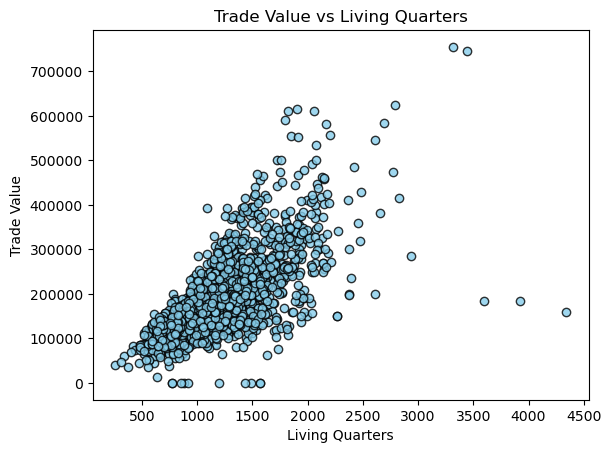

In [117]:
# Scarrerplot
plt.scatter(df['LivingQuarters'].loc[df['LivingQuarters'] != ''], df['TradeValue'], color='skyblue', edgecolor='black', alpha=0.8)
 
# Add labels and title
plt.xlabel('Living Quarters')
plt.ylabel('Trade Value')
plt.title('Trade Value vs Living Quarters')
 
# Show the plot
plt.show()

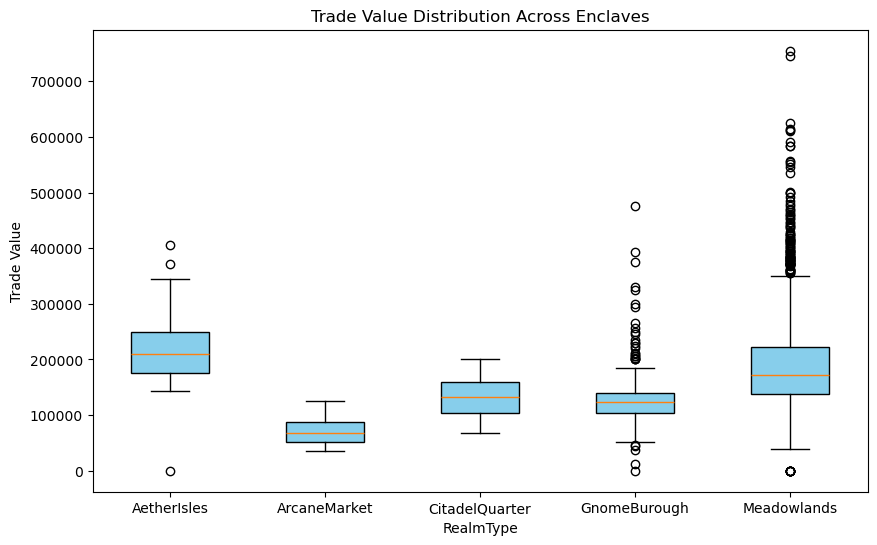

In [118]:
# Boxplot
groups = df.groupby('RealmType')['TradeValue'].apply(list)

plt.figure(figsize=(10, 6))
plt.boxplot(groups, tick_labels=groups.index, patch_artist=True, boxprops=dict(facecolor='skyblue', color='black'), whiskerprops=dict(color='black'), showfliers=True
        )

# Add labels and title
plt.xlabel('RealmType')
plt.ylabel('Trade Value')
plt.title('Trade Value Distribution Across Enclaves')

# Show the plot
plt.show()

### Data Insights: 
* Trade Value varies significantly between Realm Types. For example, properties in Aether Isles boast a much higher value than those in Arcane Market.
* The Trade Value seems to increase as the Living Quarters increase.
* There seems to be no connection between the Parcel Size and the Trade Value.

## **DATA PREPARATION**

* Any records with negative values in the ParcelSize column were removed, because it cannot be negative.
* All rows with missing values in the LivingQuarters column are filled with the median as it better represents the typical property and is less sensitive to outliers, and it prevents biasing predictions toward larger homes.
* Entries where the ParcelSize was less than 1 were removed since an extremely small parcel size is unrealistic and likely represents errors or misreported/entered size.
* Duplicate rows were identified and eliminated to prevent redundant data points from influencing predictions.

In [119]:
# Remove negative values in ParcelSize
df = df[df["ParcelSize"] >= 0]

# Fills missing LivingQuarters with the median
df["LivingQuarters"] = df["LivingQuarters"].fillna(df["LivingQuarters"].median())

# Remove rows where ParcelSize is less than 1
df = df[df["ParcelSize"] >= 1]

# Remove duplicate rows
df = df.drop_duplicates()



In [120]:
# Check the amount of rows we have left and if there are any null left values
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2318 entries, 0 to 2362
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DI              2318 non-null   int64  
 1   TradeValue      2318 non-null   float64
 2   RealmType       2318 non-null   object 
 3   Enclave         2318 non-null   object 
 4   LivingQuarters  2318 non-null   float64
 5   ParcelSize      2318 non-null   float64
 6   ParcelSizeUnit  2318 non-null   object 
dtypes: float64(3), int64(1), object(3)
memory usage: 144.9+ KB


The Enclave column was standardized by stripping unnecessary spaces, fixing inconsistent casing (lower- and uppercase). Additionally, variations of enclave names were mapped to their most frequently used correct version to prevent inconsistencies in grouping.

In [121]:
# Standardize Enclave column (strip spaces and fix casing)
df["Enclave"] = df["Enclave"].str.strip()

# Fix inconsistent enclave names
def standardize_enclave(enclave_series):
    enclave_counts = Counter(enclave_series)
    mapping = {}
    standardized_names = {}

    for enclave in enclave_counts:
        # Convert to a standard form: Capitalize 1st letter, remove the trailing 's' if it is present in the Enclave
        standardized = re.sub(r's$', '', enclave, flags=re.IGNORECASE).capitalize()

        # Keep track of the most frequent correct version
        if standardized not in standardized_names or enclave_counts[enclave] > enclave_counts.get(
                standardized_names[standardized], 0):
            standardized_names[standardized] = enclave

    # Replace variations with the most frequent correct version
    for enclave in enclave_series:
        standardized = re.sub(r's$', '', enclave, flags=re.IGNORECASE).capitalize()
        if standardized in standardized_names:
            mapping[enclave] = standardized_names[standardized]

    return enclave_series.replace(mapping)


df["Enclave"] = standardize_enclave(df["Enclave"])

# Check all unique Enclaves
print(df["Enclave"].unique())

['Shadowmere' 'Ravenstone' 'Petalbridge' 'Emberfall' 'Dragonspire'
 'Riverbend' 'Cloudrest' 'Sunspire' 'Nighthaven' 'Brightforge'
 'Wyverncliff' 'Crystalhollow' 'Wolfsbane' 'Duskwood' 'Mystvale'
 'Glimmerwood' 'Stormhold' 'Starfall' 'Silverglen' 'Thornfield'
 'Dreamweaver' 'Stormwatch' 'Windwhisper' 'Oakenshade' 'Mossheart'
 'Verdantia' 'Moonglade']


ParcelSize was converted from sqm to sqft to ensure all measurements were in a consistent unit.

In [122]:
# Convert ParcelSize to sqft if it is in sqm
conversion_factor = 10.7639  # 1 sqm = 10.76391042 sqft
df.loc[df["ParcelSizeUnit"] == "sqm", "ParcelSize"] *= conversion_factor
df.loc[df["ParcelSizeUnit"] == "sqm", "ParcelSizeUnit"] = "sqft"

In [123]:
df.to_csv("Data/set8_it1_cleaned.csv", index=False)

### **Trends**

Specific enclaves may have distinct underlying dynamics that affect trade differently. Unleashing our “imagination” for this point, some enclaves might be more commercial (supporting higher trade values), while others might be more restricted.  We have used a bar chart to show that trade values vary significantly across enclaves, showing that enclave location plays a role in determining trade value. This suggests that enclave-specific factors can drive trade value to change more than the RealmType classifications.

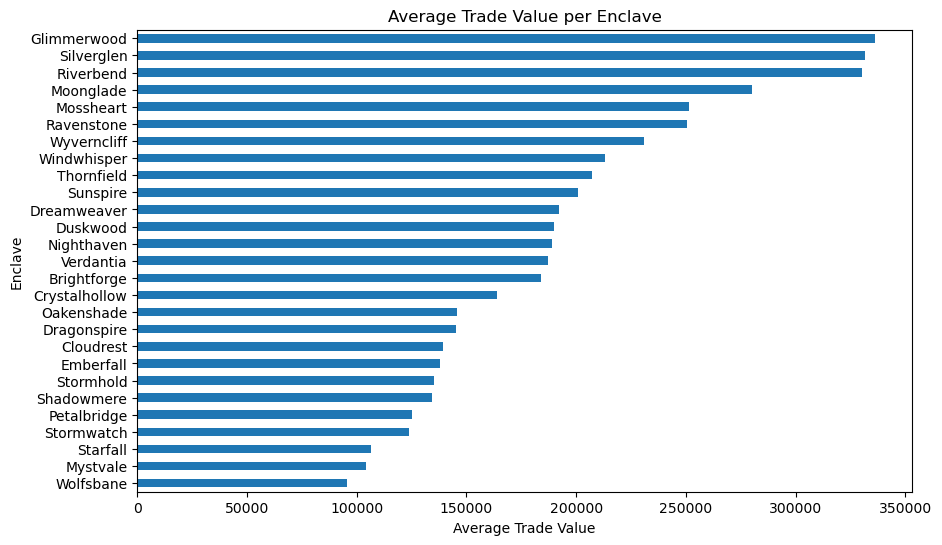

In [124]:
df.groupby("Enclave")["TradeValue"].mean().sort_values().plot(kind="barh", figsize=(10, 6))
plt.xlabel("Average Trade Value")
plt.ylabel("Enclave")
plt.title("Average Trade Value per Enclave")
plt.show()

In [125]:
df2 = df.copy()
df2 = df2.drop(columns=["ParcelSizeUnit", "RealmType", "Enclave", 'DI'])

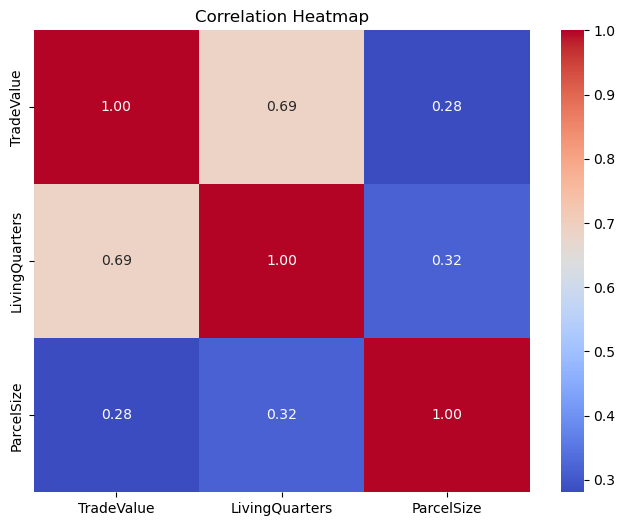

In [126]:
# Visualize the correlation with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df2.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

After we have cleaned the data, we can easily answer what are the key factors that could influence trade values and how do they vary across different enclaves. We can look into the correlation between all columns with .corr(), and can vizualize it in a heatmap for better understanding.

LivingQuarters and ParcelSize appear to have the strongest positive relationships with TradeValue. The correlation between LivingQuarters and TradeValue suggests that larger the dwelling is, the higher the trade value is. This makes sense, as larger living areas are generally associated with higher property worth. Similarly, ParcelSize has a smaller correlation but can suggest that larger parcels may have higher trade volumes.

In [127]:
df.to_csv("Data/set8_it1_cleaned.csv", index=False)

## **MODELING**

In [128]:
# The next step is to connect the prepared data from above and to use it for getting the mean and median of the TradeValue variable. 
mean_trade_value = df['TradeValue'].mean()
median_trade_value = df['TradeValue'].median()

print("The mean of the TradeValue is", mean_trade_value, "and the median is", median_trade_value)

The mean of the TradeValue is 182213.30327868852 and the median is 160500.0


We have chosen to use the median for our model because it provides a more stable central value than the mean, which is sensitive to extreme values. Since there may be outliers or errors in the dataset that we cannot fully control, using the median makes sure that one or a few extremely high or low values do not skew predictions. While the mean can be shifted by large trade values, the median remains consistent, making it a more reliable benchmark for our predictive model in a dataset with varying property values.

In [129]:
# After that we separate our data into 2 categories: categorical data and data we want to predict. They are separated in X, y respectively
df2 = df.copy()
X = df2.drop(columns=["ParcelSizeUnit", "DI", "TradeValue", "Enclave", "RealmType"], axis=1)
y = df2['TradeValue']

In [130]:
# Assign the data (70% of the data for training)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  

# Fit in the data and trained it to make predictions
value = y_train.median()
pred_train = [value] * len(y_train)
pred_test = [value] * len(y_test)

In [131]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
print(f'RMSE for the linear model on the test set: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}')
y_pred_train = model.predict(X_train)
print(f'RMSE for the linear model on the training set: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f}')

RMSE for the linear model on the test set: 55681.19
RMSE for the linear model on the training set: 60791.95


## **EVALUATION**

In [132]:
# After the predictions we are using metrics such as Mean Absolute Error and Mean squared error to see what the efficiency of our model is
mae = mean_absolute_error(y_test, pred_test) 
mse = mean_squared_error(y_test, pred_test)

print("The MAE is", mae)
print("The MSE is", mse)

The MAE is 54498.995689655174
The MSE is 6533157540.837644


Our model’s predictions are, on average, 54,498 magical coins currency off from the actual trade values (MAE – mean absolute error). For properties in high-value enclaves, where it is more challenging to estimate high prices, the Mean Squared Error (MSE) further demonstrates that certain estimates contain substantially bigger errors. These results show that the complexity of property price across many realms are not accurately represented by using the mean or median trade value as a prediction benchmark alone.

Trade values are mainly influenced by RealmType, LivingQuarters size, and Enclave. Larger LivingQuarters generally lead to higher prices. Some enclaves, like ‘Shadowmere‘and ‘Ravenstone‘, consistently have higher property values, while others, like ‘Emberfall‘ and ‘Dragonspire‘, fall in the mid-range. This suggests that location within a realm has a significant impact on pricing, and different enclaves may have unique economic or magical influences affecting property worth.

One major problem with our model is that while it performs reasonably well on training data, its errors remain large when tested on new validation data. This occurs because the model does not fully capture the relationships between RealmType, LivingQuarters, and Enclave. To better understand this issue, we need to analyse specific validation set errors - check whether mispredictions occur in specific enclaves, dwelling sizes, or extreme trade values. To improve accuracy, besides needing more data, we should test alternative more complex models and adapt our approach to recognize these patterns better. Additionally, using a cross-validation can help ensure that the model generalizes well to new data and does not just memorize patterns from the training set.
